In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
data = yf.download('0005.hk',"2017-01-01","2021-12-30")
data.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-01-03  62.250000  63.150002  62.200001  63.000000  50.812317  11331063
2017-01-04  63.450001  63.450001  62.950001  63.450001  51.175259  13426502
2017-01-05  63.799999  63.950001  63.549999  63.900002  51.538197  12484357
2017-01-06  63.900002  63.900002  63.349998  63.750000  51.417221  14321890
2017-01-09  63.599998  63.849998  63.299999  63.700001  51.376904  10499807

In [3]:
data['Prediction'] = data[['Close']].shift(-1)

In [4]:
data.drop('Adj Close',1,inplace=True)
data.dropna(inplace=True)
data.isnull().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
Prediction    0
dtype: int64

In [5]:
data.head()

Open       High        Low      Close    Volume  Prediction
Date                                                                        
2017-01-03  62.250000  63.150002  62.200001  63.000000  11331063   63.450001
2017-01-04  63.450001  63.450001  62.950001  63.450001  13426502   63.900002
2017-01-05  63.799999  63.950001  63.549999  63.900002  12484357   63.750000
2017-01-06  63.900002  63.900002  63.349998  63.750000  14321890   63.700001
2017-01-09  63.599998  63.849998  63.299999  63.700001  10499807   63.349998

In [6]:
data_price=data["Prediction"].values.reshape(-1,1)[:-15]
train=data.drop(['Prediction'],1).dropna().values[:-15]
sc_x = MinMaxScaler(feature_range=(0,1))
# sc_y = MinMaxScaler(feature_range=(0,1))
train=sc_x.fit_transform(train)
# data_price = sc_y.fit_transform(data_price)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb,len(data)-lb-1):
        X.append(data[i-(lb):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=10
X,y = processData(train,data_price,lb)
data_x=X[:-15]
data_y=y[:-15]
X_train,X_test = data_x[:int(data_x.shape[0]*0.90)],data_x[int(data_x.shape[0]*0.90):]
y_train,y_test = data_y[:int(data_y.shape[0]*0.90)],data_y[int(data_y.shape[0]*0.90):]
# print(type(X_train))
print(X.shape)
print(y.shape)

(1194, 10, 5)
(1194, 1)


In [7]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1061, 10, 5) (1061, 1) (118, 10, 5) (118, 1)


In [8]:
X_val=X_test[-18:]
X_test=X_test[:-18]
y_val=y_test[-18:]
y_test=y_test[:-18]

In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape= (X_train.shape[1], X_train.shape[2]),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.0))
# model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [10]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 10, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 74,865
Trainable params: 74,865
Non-trainable params: 0
____________________________________________________

In [11]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=100,batch_size=20,validation_data=(X_val,y_val),shuffle=False,callbacks=[es])

Epoch 1/100
54/54 [==============================] - 12s 17ms/step - loss: 3916.4230 - val_loss: 14.8479
Epoch 2/100
54/54 [==============================] - 0s 7ms/step - loss: 328.4586 - val_loss: 13.5641
Epoch 3/100
54/54 [==============================] - 0s 7ms/step - loss: 427.5210 - val_loss: 57.5807
Epoch 4/100
54/54 [==============================] - 0s 7ms/step - loss: 336.5657 - val_loss: 47.4008
Epoch 5/100
54/54 [==============================] - 0s 7ms/step - loss: 323.2758 - val_loss: 326.8670
Epoch 6/100
54/54 [==============================] - 0s 7ms/step - loss: 245.5250 - val_loss: 142.5319
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 191.9475 - val_loss: 89.3076
Epoch 8/100
54/54 [==============================] - 0s 7ms/step - loss: 251.7522 - val_loss: 77.3335
Epoch 9/100
54/54 [==============================] - 0s 7ms/step - loss: 194.6564 - val_loss: 26.0634
Epoch 10/100
54/54 [==============================] - 0s 7ms/step - loss: 39.

54/54 [==============================] - 0s 6ms/step - loss: 91.3415 - val_loss: 12.6335
Epoch 82/100
54/54 [==============================] - 0s 7ms/step - loss: 82.9681 - val_loss: 33.8215
Epoch 83/100
54/54 [==============================] - 0s 7ms/step - loss: 84.3838 - val_loss: 5.5973
Epoch 84/100
54/54 [==============================] - 0s 7ms/step - loss: 84.2170 - val_loss: 29.3906
Epoch 85/100
54/54 [==============================] - 0s 7ms/step - loss: 83.7545 - val_loss: 16.4047
Epoch 86/100
54/54 [==============================] - 0s 7ms/step - loss: 86.3271 - val_loss: 10.8894
Epoch 87/100
54/54 [==============================] - 0s 7ms/step - loss: 82.4987 - val_loss: 35.8296
Epoch 88/100
54/54 [==============================] - 0s 7ms/step - loss: 84.6030 - val_loss: 4.3088
Epoch 89/100
54/54 [==============================] - 0s 7ms/step - loss: 70.7902 - val_loss: 32.0934
Epoch 90/100
54/54 [==============================] - 0s 7ms/step - loss: 75.5280 - val_loss: 6.1

In [12]:
y_pred = model.predict(X_test)

In [13]:
y_pred.shape

(100, 1)

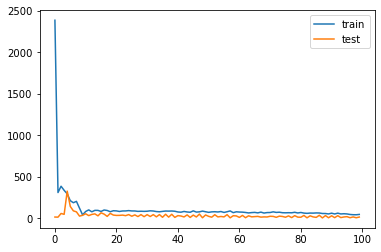

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

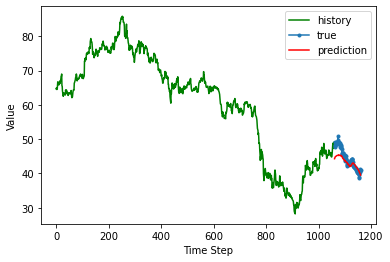

In [15]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [16]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test
# y_test=sc_y.inverse_transform(y_test)
# y_pred=sc_y.inverse_transform(y_pred)

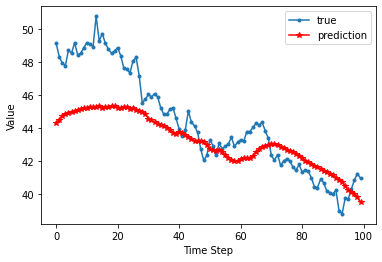

In [17]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
mean_absolute_percentage_error(y_test,y_pred)*100

3.6029449115273753

In [19]:
mean_squared_error(y_test,y_pred)

4.378632178198168

In [20]:
r2_score(y_test,y_pred)

0.5416885092712613

# Unseen data

In [22]:
forecast_data = X[-15:]
forecast = y[-15:]
# forecast=sc_y.inverse_transform(forecast) 
print(forecast)

[[46.95000076]
 [47.04999924]
 [46.84999847]
 [47.15000153]
 [45.45000076]
 [45.70000076]
 [45.54999924]
 [45.29999924]
 [45.45000076]
 [45.29999924]
 [45.20000076]
 [45.79999924]
 [46.        ]
 [46.04999924]
 [46.04999924]]


In [25]:
prediction = model.predict(forecast_data).reshape(-1,1)
# prediction = sc_y.inverse_transform(prediction) 
print(prediction)

[[44.177032]
 [44.27563 ]
 [44.30889 ]
 [44.37577 ]
 [44.43083 ]
 [44.47046 ]
 [44.271126]
 [44.23445 ]
 [44.21848 ]
 [44.082783]
 [44.036148]
 [43.997215]
 [43.95128 ]
 [43.89558 ]
 [43.862343]]


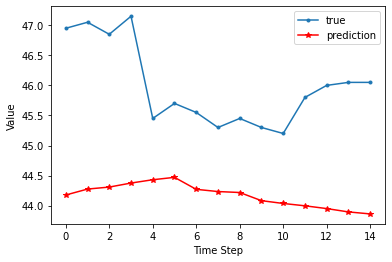

In [26]:
plt.plot(forecast, marker='.', label="true")
plt.plot(prediction, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
mean_absolute_percentage_error(forecast,prediction)*100

In [ ]:
r2_score(forecast,prediction)